# PLS2 
## Examining proteomic and DTI data in UKB

Issue of multicollinearity in as predictor variables in this dataset (proteins) are highly correlated.

One way to get around this problem is to use a method known as partial least squares (PLS). 

Here I aim to:

* Standardize both the predictor and response variables.
* Calculate M linear combinations (called “PLS components”) of the original p predictor variables that explain a significant amount of variation in both the response variable and the predictor variables.
* Use the method of least squares to fit a linear regression model using the PLS components as predictors.
* Use k-fold cross-validation to find the optimal number of PLS components to keep in the model.


In [1]:
!pip install pandas

# PLS2 for proteomics and DTI data initial test run

In [2]:
import pandas as pd

In [3]:
!pip install pyarrow

In [4]:
!pip install numpy
!pip install scikit-learn

In [5]:
!pip install matplotlib

In [6]:
# Load relevant packages 
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

# Load relevant data for pilot test

In [7]:
# Check what's in directory
import os

current_directory = os.getcwd()

print(current_directory)

/Users/eleanorc_worklaptop/Desktop/UKB_Proteomics/UKB_PPP_python


In [8]:
proteomics = "/Users/eleanorc_worklaptop/Desktop/UKB_Proteomics/UKB_PPP_python/ST3_UKB_proteins.csv"
df_p_data = pd.read_csv(proteomics)
df_p_data

,UKBPPP ProteinID,Olink ID,Assay Target,Protein panel,Gene symbol,UniProt,Gene CHROM,Gene start,Gene end,Dilution factor,% of samples below LOD,Coefficient of variation (median %)
0,AARSD1:Q9BTE6:OID21311:v1,OID21311,AARSD1,Oncology,AARSD1,Q9BTE6,17,42950526,42964498,1:1,0.05%,4.78
1,ABHD14B:Q96IU4:OID20921:v1,OID20921,ABHD14B,Neurology,ABHD14B,Q96IU4,3,51968510,51983409,1:1,0.04%,8.97
2,ABL1:P00519:OID21280:v1,OID21280,ABL1,Oncology,ABL1,P00519,9,130713016,130887675,1:1,0.04%,6.03
3,ACAA1:P09110:OID21269:v1,OID21269,ACAA1,Oncology,ACAA1,P09110,3,38103129,38137242,1:1,17.20%,12.97
4,ACAN:P16112:OID20159:v1,OID20159,ACAN,Cardiometabolic,ACAN,P16112,15,88803436,88875353,1:10,0.13%,6.18
...,...,...,...,...,...,...,...,...,...,...,...,...
1467,XRCC4:Q13426:OID20869:v1,OID20869,XRCC4,Neurology,XRCC4,Q13426,5,83077498,83353787,1:1,80.94%,7.55
1468,YES1:P07947:OID21348:v1,OID21348,YES1,Oncology,YES1,P07947,18,721588,812546,1:1,0.04%,10.59
1469,YTHDF3:Q7Z739:OID20478:v1,OID20478,YTHDF3,Inflammation,YTHDF3,Q7Z739,8,63168553,63212786,1:1,10.88%,13.11
1470,ZBTB16:Q05516:OID21205:v1,OID21205,ZBTB16,Oncology,ZBTB16,Q05516,11,114059041,114256765,1:1,0.51%,8.49


In [9]:
# Load DTI data
neuroimaging_subset = "/Users/eleanorc_worklaptop/Desktop/UKB_Proteomics/UKB_PPP_python/merged_data.csv"

df_neuroimaging = pd.read_csv(neuroimaging_subset)

df_neuroimaging

,Unnamed: 0,eid,GZMB,GRPEL1,GSAP,GSTA1,GSTA3,GSTP1,GUCA2A,GUSB,...,lML_FA,rML_FA,lPTR_FA,rPTR_FA,lSLF_FA,rSLF_FA,lSTR_FA,rSTR_FA,lUnc_FA,rUnc_FA
0,1,1000573,0.18050,0.44505,0.3517,0.87555,0.59995,0.4293,0.13085,0.90860,...,0.425137,0.438404,0.477601,0.466786,0.486486,0.435698,0.434628,0.437619,0.414991,0.403708
1,2,1000893,0.88645,0.69160,0.6700,1.24515,0.67090,0.8054,0.22295,0.17655,...,0.407959,0.397717,0.445529,0.457740,0.453780,0.433911,0.409192,0.423134,0.378078,0.373331
2,3,1001028,1.37140,0.78770,2.0522,0.46210,0.73440,0.3075,0.71600,0.40510,...,0.410745,0.450009,0.477916,0.441603,0.451860,0.430216,0.422117,0.421530,0.376068,0.365023
3,4,1003537,0.57010,0.43875,0.3803,0.43135,0.28970,0.4099,0.00475,0.62660,...,0.430355,0.439236,0.491488,0.471265,0.450530,0.446036,0.429410,0.430935,0.412622,0.406120
4,5,1004616,1.19495,0.83780,0.2743,0.56105,0.31370,1.5987,0.33875,0.13995,...,0.410290,0.408738,0.474783,0.450130,0.447044,0.431624,0.451923,0.441271,0.368224,0.360642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4639,4640,6018609,0.00650,0.45365,0.4506,1.42485,1.10560,0.6354,0.66945,0.28730,...,0.463914,0.468890,0.445366,0.452633,0.430563,0.407339,0.427389,0.405904,0.363829,0.351309
4640,4641,6019358,0.49865,0.02620,0.5769,0.61225,0.49330,0.5430,0.55165,1.00795,...,0.420189,0.414230,0.451537,0.454354,0.427003,0.419351,0.419468,0.429952,0.370552,0.380164
4641,4642,6021143,0.10620,2.29245,0.1899,0.03165,0.36700,1.0386,0.13275,1.36590,...,0.413580,0.398320,0.468904,0.474296,0.457283,0.457668,0.439893,0.454022,0.429197,0.464371
4642,4643,6021217,0.02515,0.15630,0.4839,0.79975,4.44390,0.0259,0.15815,0.19085,...,0.432379,0.425174,0.444384,0.479776,0.454680,0.449540,0.431674,0.433359,0.397299,0.383125


In [10]:
# Tidy this df
df_neuroimaging.drop(columns=['eid'], inplace=True)
df_neuroimaging.head()

,Unnamed: 0,GZMB,GRPEL1,GSAP,GSTA1,GSTA3,GSTP1,GUCA2A,GUSB,GYS1,...,lML_FA,rML_FA,lPTR_FA,rPTR_FA,lSLF_FA,rSLF_FA,lSTR_FA,rSTR_FA,lUnc_FA,rUnc_FA
0,1,0.18050,0.44505,0.3517,0.87555,0.59995,0.4293,0.13085,0.90860,0.20335,...,0.425137,0.438404,0.477601,0.466786,0.486486,0.435698,0.434628,0.437619,0.414991,0.403708
1,2,0.88645,0.69160,0.6700,1.24515,0.67090,0.8054,0.22295,0.17655,0.86730,...,0.407959,0.397717,0.445529,0.457740,0.453780,0.433911,0.409192,0.423134,0.378078,0.373331
2,3,1.37140,0.78770,2.0522,0.46210,0.73440,0.3075,0.71600,0.40510,2.33680,...,0.410745,0.450009,0.477916,0.441603,0.451860,0.430216,0.422117,0.421530,0.376068,0.365023
3,4,0.57010,0.43875,0.3803,0.43135,0.28970,0.4099,0.00475,0.62660,0.97315,...,0.430355,0.439236,0.491488,0.471265,0.450530,0.446036,0.429410,0.430935,0.412622,0.406120
4,5,1.19495,0.83780,0.2743,0.56105,0.31370,1.5987,0.33875,0.13995,0.92150,...,0.410290,0.408738,0.474783,0.450130,0.447044,0.431624,0.451923,0.441271,0.368224,0.360642


In [11]:
# Assign white matter tracts and proteins from dataframes

wm_cols = ["FMaj_FA", "FMin_FA", "lAR_FA", "lATR_FA", "lCingG_FA", "lCingPH_FA",
           "lCST_FA", "lIFOF_FA", "lILF_FA", "lML_FA", "lPTR_FA", "lSLF_FA",
           "lSTR_FA", "lUnc_FA", "MCP_FA", "rAR_FA", "rATR_FA", "rCingG_FA",
           "rCingPH_FA", "rCST_FA", "rIFOF_FA", "rILF_FA", "rML_FA", "rPTR_FA",
           "rSLF_FA", "rSTR_FA", "rUnc_FA"]

wm = df_neuroimaging[wm_cols]

proteins = df_neuroimaging[[col for col in df_neuroimaging.columns if col not in wm_cols]]

proteins

,Unnamed: 0,GZMB,GRPEL1,GSAP,GSTA1,GSTA3,GSTP1,GUCA2A,GUSB,GYS1,...,PRDX1,NAAA,NGF,MITD1,MMP1,OBP2B,PCOLCE,PAEP,NPM1,NMNAT1
0,1,0.18050,0.44505,0.3517,0.87555,0.59995,0.4293,0.13085,0.90860,0.20335,...,0.34580,1.0442,0.0900,0.67620,0.74310,0.49010,0.039624,1.86860,0.011198,0.0622
1,2,0.88645,0.69160,0.6700,1.24515,0.67090,0.8054,0.22295,0.17655,0.86730,...,1.22255,1.0864,0.0038,1.36675,0.44735,0.70345,0.039624,3.49205,0.515900,1.2389
2,3,1.37140,0.78770,2.0522,0.46210,0.73440,0.3075,0.71600,0.40510,2.33680,...,1.47190,0.3559,0.0624,1.56560,1.45220,1.18670,0.039624,0.00000,0.011198,0.1559
3,4,0.57010,0.43875,0.3803,0.43135,0.28970,0.4099,0.00475,0.62660,0.97315,...,0.02150,0.3292,0.0640,0.41860,1.32090,1.41025,0.039624,1.36310,0.011198,0.9298
4,5,1.19495,0.83780,0.2743,0.56105,0.31370,1.5987,0.33875,0.13995,0.92150,...,0.30125,0.4677,0.0376,0.72735,0.58605,0.85185,0.039624,0.16445,0.011198,0.9957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4639,4640,0.00650,0.45365,0.4506,1.42485,1.10560,0.6354,0.66945,0.28730,0.39795,...,0.52620,0.4138,0.3772,0.36270,0.36140,1.02420,0.306250,0.92680,0.011198,0.7953
4640,4641,0.49865,0.02620,0.5769,0.61225,0.49330,0.5430,0.55165,1.00795,0.50570,...,1.00565,0.5498,0.2122,0.59325,0.62125,0.05985,0.009800,1.64825,0.251700,0.1440
4641,4642,0.10620,2.29245,0.1899,0.03165,0.36700,1.0386,0.13275,1.36590,0.57045,...,0.52640,0.3326,0.0231,0.12760,1.95350,0.02335,0.039624,0.44200,0.011198,0.5101
4642,4643,0.02515,0.15630,0.4839,0.79975,4.44390,0.0259,0.15815,0.19085,0.15670,...,0.16195,0.1605,0.1358,0.75825,0.61365,0.03335,0.039624,1.31365,0.011198,0.1079


## Build a dictionary

In [12]:
# Create a dictionary called lookup based on information obtained from the proteins df and other predefined dictionaries and lists
lookup = {}

colors = {"Inflammation": "tab:red", "Neurology": "tab:blue", "Cardiometabolic": "tab:orange", "Oncology": "tab:green"}

for index in range(0,len(proteins.columns)):
    name = proteins.columns[index]
    panel = df_p_data[df_p_data['Assay Target'] == name]['Protein panel'].to_list()
    if index == 0:
        panel = ""
        color = "tab:grey"
    else:
        panel = panel[0]
        color = colors[panel]
    lookup[index] = {"name": name, "panel": panel, "color": color}

#lookup

In [13]:
def dictionary_head(dictionary, num_items=5):
    """
    Display the first 'num_items' key-value pairs from a dictionary.
    
    Args:
    dictionary (dict): The dictionary to display.
    num_items (int): Number of items to display (default is 5).
    """
    items_to_display = list(dictionary.items())[:num_items]
    for key, value in items_to_display:
        print(f"{key}: {value}")

# run function to glimpse() / skimr::skim()
dictionary_head(lookup)

0: {'name': 'Unnamed: 0', 'panel': '', 'color': 'tab:grey'}
1: {'name': 'GZMB', 'panel': 'Inflammation', 'color': 'tab:red'}
2: {'name': 'GRPEL1', 'panel': 'Oncology', 'color': 'tab:green'}
3: {'name': 'GSAP', 'panel': 'Oncology', 'color': 'tab:green'}
4: {'name': 'GSTA1', 'panel': 'Cardiometabolic', 'color': 'tab:orange'}


In [14]:
# Test our dictionary : 
lookup[1]

{'name': 'GZMB', 'panel': 'Inflammation', 'color': 'tab:red'}

In [15]:
# match up items
df2 = df_p_data[['Assay Target', 'Protein panel']]

df2[df2['Assay Target'] == 'THBS4']

,Assay Target,Protein panel
1352,THBS4,Cardiometabolic


## Run PLS2

In [16]:
# PLS2 attempt
pls2 = PLSRegression(n_components=2)

pls2.fit(proteins, wm)

PLSRegression()

In [17]:
[lookup[i]['color'] for i in range(0,len(pls2.x_loadings_))]

['tab:grey',
 'tab:red',
 'tab:green',
 'tab:green',
 'tab:orange',
 'tab:green',
 'tab:blue',
 'tab:blue',
 'tab:orange',
 'tab:orange',
 'tab:red',
 'tab:green',
 'tab:orange',
 'tab:green',
 'tab:green',
 'tab:blue',
 'tab:green',
 'tab:blue',
 'tab:green',
 'tab:green',
 'tab:red',
 'tab:blue',
 'tab:red',
 'tab:green',
 'tab:orange',
 'tab:green',
 'tab:green',
 'tab:orange',
 'tab:green',
 'tab:blue',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:blue',
 'tab:red',
 'tab:red',
 'tab:green',
 'tab:green',
 'tab:blue',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:blue',
 'tab:orange',
 'tab:red',
 'tab:orange',
 'tab:red',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:red',
 'tab:orange',
 'tab:green',
 'tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:red',
 'tab:blue',
 'tab:red',
 'tab:green',
 'tab:blue',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:red',
 'tab:red',
 'tab:green',
 'tab:orange',
 'tab:red',
 'tab:red',
 'tab:green',
 'tab:orange',

## Work out how many components to use

### See how much variance is explained by components 

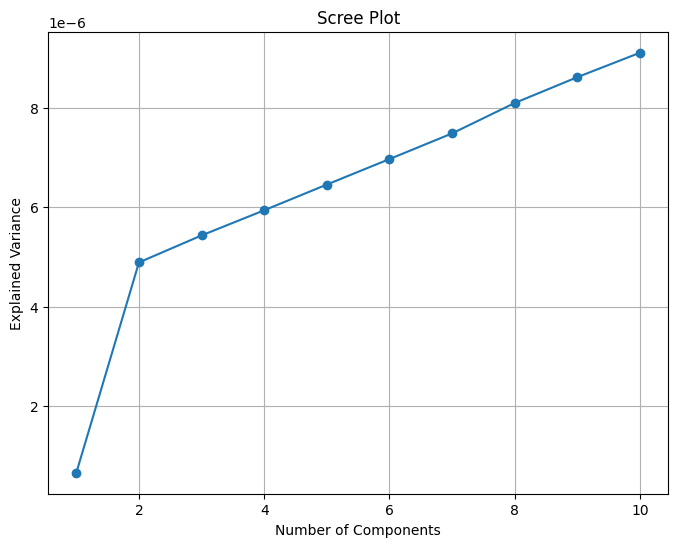

In [28]:
# Work out how many components to use

# This takes a while to run

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Create and fit your PLS model (example)
# n_components_max = 15  # Set the maximum number of components to explore
n_components_max = 10  # Set the maximum number of components to explore
X = proteins  # Sample data
Y = wm   # Sample data

explained_variance = []  # Initialize a list to store explained variance for each component

for n_components in range(1, n_components_max + 1):
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    
    # Calculate the explained variance for the current number of components
    explained_variance.append(np.var(pls.x_scores_, axis=0).sum() / np.var(X, axis=0).sum())

# Create a Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components_max + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance / MSE')
plt.title('Scree Plot')
plt.grid(True)

# Show the Scree Plot
plt.show()

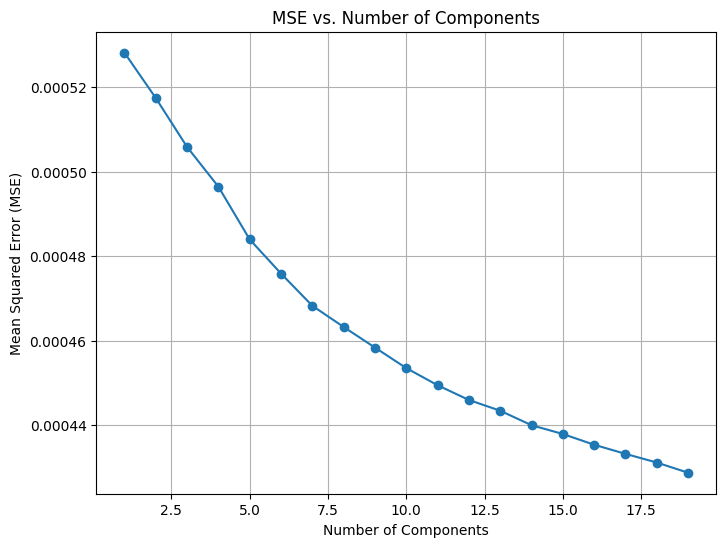

In [32]:
# PLotting MSE which is like R2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

# Create your X and Y data (replace with your actual data)
X = proteins  # Sample data
Y = wm   # Sample data

# Define a range of components to explore
components_range = range(1, 20)  # Adjust the range as needed

# Initialize an empty list to store MSE values
mse_values = []

# Fit PLS2 models with different numbers of components and calculate MSE
for n_components in components_range:
    pls2 = PLSRegression(n_components=n_components)
    pls2.fit(X, Y)
    
    # Make predictions
    y_pred = pls2.predict(X)
    
    # Calculate MSE
    mse = mean_squared_error(Y, y_pred)
    
    # Append MSE to the list
    mse_values.append(mse)

# Plot MSE against the number of components
plt.figure(figsize=(8, 6))
plt.plot(components_range, mse_values, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Number of Components')
plt.grid(True)

# Show the plot
plt.show()

# What you need to do next:

*  Run PLS2 with X components (e.g. 15)
*  Take the X loadings matrix and take the absolute values across the proteins direction (dimension number 1) and also take the mean across this same dimension. This gives us a single combined loadings plot which gives you the average of all the loadings.

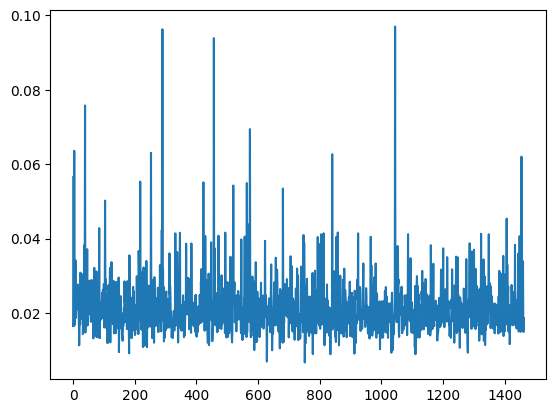

In [47]:
# This tells us for a 19 component model 
# Across all 19 components, this tells us the importance of specific proteins across 19 components 
# This is a plot of protein importance across all of the components 

plt.plot(np.mean(np.abs(pls2.x_loadings_), axis=1))

# Plot of relative importance of proteins in driving white matter (FA) integrity across 27 tracts

## Data reduction step

* This analysis justifies placing our attention on all of the white matter tracts and the following proteins

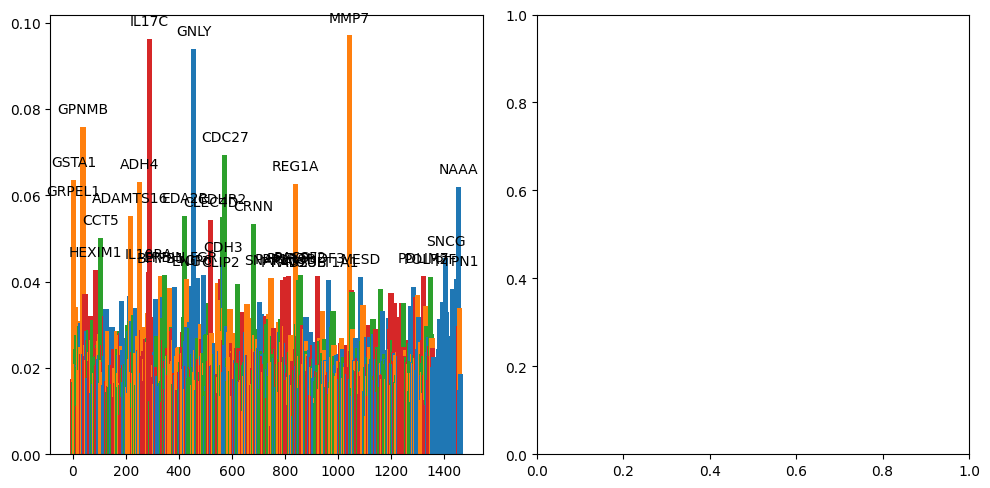

In [50]:
# Set your threshold value
threshold_value = 0.04  # Adjust this threshold as needed

mean_loading = np.mean(np.abs(pls2.x_loadings_), axis=1)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a list of bar colors based on values from the 'lookup' dictionary
bar_colors = [lookup[i]['color'] for i in range(len(pls2.x_loadings_))]

# Plot the first set of loadings
ax1.bar(range(len(pls2.x_loadings_)), mean_loading, width=20, color=bar_colors)
ax1.set_title('')

# Label the bars with protein names for those bars where the loading is greater than the threshold
for i, loading_value in enumerate(mean_loading):
    if abs(loading_value) > threshold_value:
        ax1.annotate(proteins.columns[i], (i, loading_value), textcoords="offset points", xytext=(0, 10), ha='center')

for i, loading_value in enumerate(mean_loading):
    if abs(loading_value) > threshold_value:
        ax2.annotate(proteins.columns[i], (i, loading_value), textcoords="offset points", xytext=(0, 10), ha='center')

# Adjust plot layout
plt.tight_layout()

# Show the plots
plt.show()

# Future work:
## 1). Repeat this analysis with just the above proteins that have been idenitified as important 

* If the screeplot for just ~ 30 relevant proteins (MSE) is similiar, then most of the other proteins are redundant for explaining this relationship.
* It would be a strong case for certain proteins /pathways being more important for white matter health
* Here, you could train a NN to do this prediction (pls.fit) and again compare the MSE and the prediction
* I.e. compare a non-linear model to this linear model to see why, if NN performs better this strongly suggests non-linear methods better

# Some notes:
## When controlling for BMI, etc.

* concatenate relevant covariates in with predictors (aka proteins) - important scaling to consider
* Extract MSE from this
* Do this across different test-train samples
* End up with two MSE values, compare them as you would two R2 values in linear regression

## Further notes: When controlling for BMI, etc.
* Put covariates in but do not show in plot
* Theoretically, one of the components could explain the variance in the direction of BMI etc.
* Strictly, you can actually remove the influence statistically from the dataset:
* but I think this could be confusing to explain
* could control for it by modelling all of the variance relating to BMI etc.

# No specific white matter tract dominates this relationship
## This justifies use of gFA I think

* the following plot justifies collapsing the FA data into a single aggregate score

<BarContainer object of 27 artists>

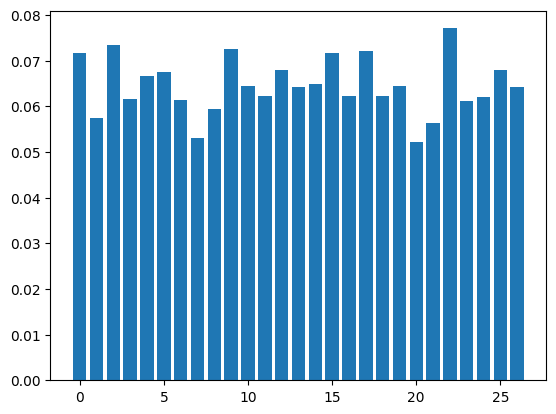

In [46]:
plt.bar(range(0, 27), np.mean(np.abs(pls2.y_loadings_), axis=1))

# Split the data into testing and training

* Split this dataset into a training sample (75% of dataset)
* and into a test set (25% of dataset)

Do this to prevent overfitting (arbritarily adding components that explain incremental variance that may be as a result of overfitting to our dataset)

# Plot PLS2 loadings
The code below will create two side-by-side bar plots (ax1 and ax2) to visualize the loadings of the X variables for the first and second components. Each bar in the plot represents the loading value of a specific X variable, and the bars are colored based on a color scheme specified in the bar_colors list that relates to which protein panel the proteomic data is from. 

The color is determined by looking up the corresponding value in the lookup dictionary, which likely contains information about the X variables (aka their respective panels) and the associated colors assigned to these:

colors = {"Inflammation": "tab:red", "Neurology": "tab:blue", "Cardiometabolic": "tab:orange", "Oncology": "tab:green"}

<BarContainer object of 1464 artists>

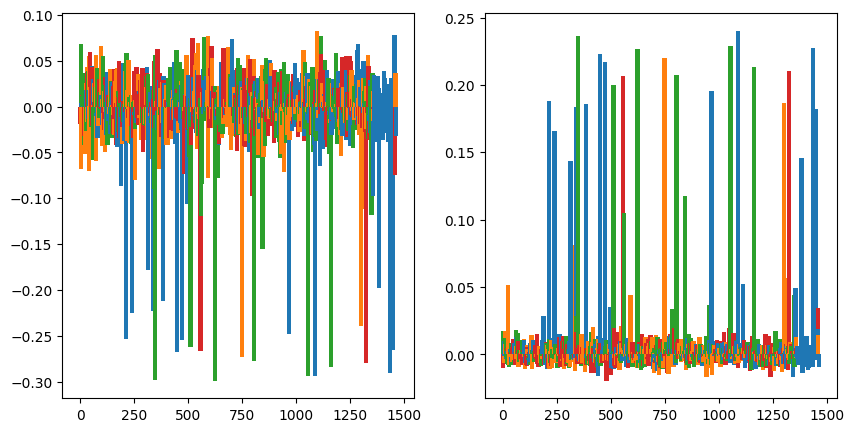

In [18]:
# Plot these loadings
# loadings of the X variables in the PLS2 model. 
# Loadings represent the contribution of each variable to the latent factors (components) extracted by PLS2. 
# focusing on the first two loadings ([:, 0] and [:, 1]), which are associated with the first and second components.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

bar_colors =[lookup[i]['color'] for i in range(0,len(pls2.x_loadings_))]

ax1.bar(range(0, len(pls2.x_loadings_)), pls2.x_loadings_[:,0], width=20, color=bar_colors)
ax2.bar(range(0, len(pls2.x_loadings_)), pls2.x_loadings_[:,1], width=20, color=bar_colors)

## Label plots: identify proteins with significant contributions

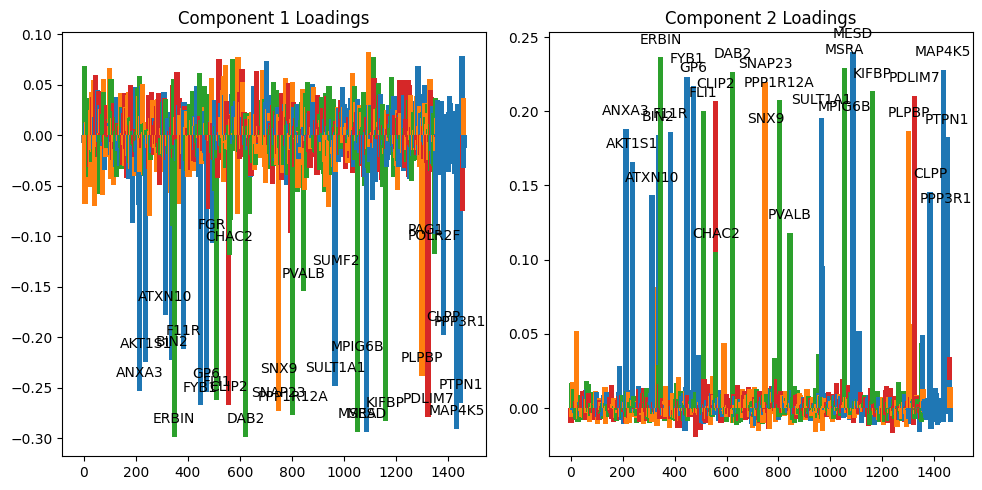

In [19]:
# Test code
import matplotlib.pyplot as plt

# Set your threshold value
threshold_value = 0.10  # Adjust this threshold as needed

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a list of bar colors based on values from the 'lookup' dictionary
bar_colors = [lookup[i]['color'] for i in range(len(pls2.x_loadings_))]

# Plot the first set of loadings
ax1.bar(range(len(pls2.x_loadings_)), pls2.x_loadings_[:, 0], width=20, color=bar_colors)
ax1.set_title('Component 1 Loadings')

# Plot the second set of loadings
ax2.bar(range(len(pls2.x_loadings_)), pls2.x_loadings_[:, 1], width=20, color=bar_colors)
ax2.set_title('Component 2 Loadings')

# Label the bars with protein names for those bars where the loading is greater than the threshold
for i, loading_value in enumerate(pls2.x_loadings_[:, 0]):
    if abs(loading_value) > threshold_value:
        ax1.annotate(proteins.columns[i], (i, loading_value), textcoords="offset points", xytext=(0, 10), ha='center')

for i, loading_value in enumerate(pls2.x_loadings_[:, 1]):
    if abs(loading_value) > threshold_value:
        ax2.annotate(proteins.columns[i], (i, loading_value), textcoords="offset points", xytext=(0, 10), ha='center')

# Adjust plot layout
plt.tight_layout()

# Show the plots
plt.show()


<BarContainer object of 27 artists>

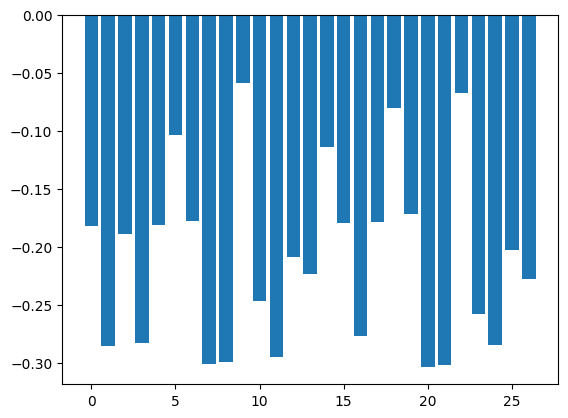

In [22]:
import matplotlib.pyplot as plt

plt.bar(range(0, 27), pls2.y_loadings_[:, 0])

## Scatter plot of Latent Variables (LVs)

The scatter plot allows you to visualize the relationships between LVs derived from protein data and LVs derived from DTI data. Each point on the scatter plot represents a sample (or subject), and its position is determined by the values of the LVs for both datasets.

PLS2 (Partial Least Squares Type 2) is a technique for integrating information from two or more datasets to identify associations or relationships between them. The scatter plot shows how well the LVs from the protein data align or correlate with the LVs from the DTI data. If there are clear patterns or clusters, it indicates a potential relationship between protein expression and DTI metrics.

In [23]:
lv_scores = pls2.x_scores_

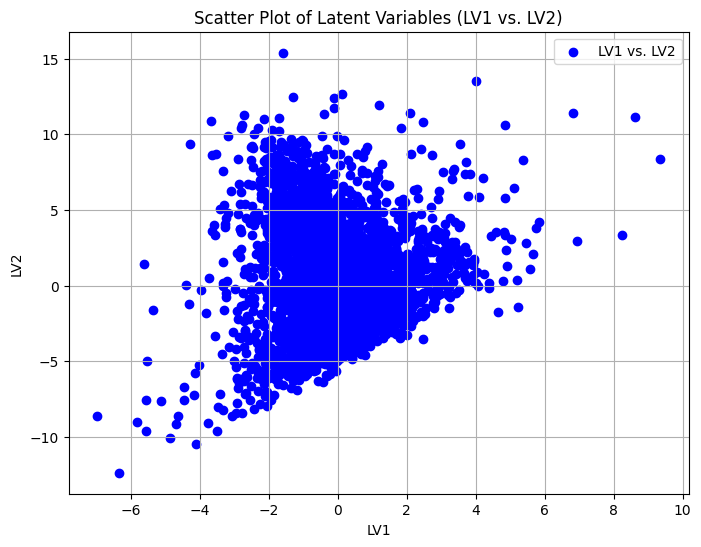

In [24]:
import matplotlib.pyplot as plt

# Assuming 'lv_scores' contains the LV scores from your PLS2 model
# 'lv_scores' should be a two-dimensional array with LV scores in columns

# Extract the first and second LVs (columns 0 and 1)
lv1 = lv_scores[:, 0]
lv2 = lv_scores[:, 1]

# Create a scatter plot of LV1 vs. LV2
plt.figure(figsize=(8, 6))
plt.scatter(lv1, lv2, c='b', marker='o', label='LV1 vs. LV2')

# Add labels and title
plt.xlabel('LV1')
plt.ylabel('LV2')
plt.title('Scatter Plot of Latent Variables (LV1 vs. LV2)')

# Add legend if needed
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


# Loadings plot

In [ ]:
# Following code not validated 

In [ ]:
proteins.columns[i]

In [ ]:
# Variable loadings plot

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pls2' is your fitted PLS2 model
# Extract variable loadings for the first LV (modify for other LVs)
variable_loadings = pls2.x_loadings_[:, 0]

# Extract variable names or labels from your data (modify as needed)
# Replace 'variable_names' with your actual variable names or labels
#variable_names = ['Variable1', 'Variable2', 'Variable3', ...]

variable_names = proteins.columns

#wm_cols = ["FMaj_FA", "FMin_FA", "lAR_FA", "lATR_FA", "lCingG_FA", "lCingPH_FA",
#           "lCST_FA", "lIFOF_FA", "lILF_FA", "lML_FA", "lPTR_FA", "lSLF_FA",
#           "lSTR_FA", "lUnc_FA", "MCP_FA", "rAR_FA", "rATR_FA", "rCingG_FA",
#           "rCingPH_FA", "rCST_FA", "rIFOF_FA", "rILF_FA", "rML_FA", "rPTR_FA",
#           "rSLF_FA", "rSTR_FA", "rUnc_FA"]

#proteins.columns[i]

# Create a bar plot of variable loadings
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(variable_loadings)), variable_loadings, color='b', alpha=0.7, align='center')

# Customize plot labels and title
plt.xlabel('X Variables')
plt.ylabel('Variable Loadings (LV1)')
plt.title('Variable Loadings Plot (LV1)')

# Add variable names as x-axis labels
plt.xticks(np.arange(len(variable_names)), variable_names, rotation=45, size=6)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
proteins.columns

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pls2' is your fitted PLS2 regression model
# Extract regression coefficients (b-coefficients) for the first LV (modify for other LVs)
coefficients = pls2.coef_[:, 0]

# Extract variable names or labels from your data (modify as needed)
# Replace 'variable_names' with your actual variable names or labels
variable_names = ['Variable1', 'Variable2', 'Variable3', ...]
#variable_names = proteins.columns
variable_names = wm_cols

# Create a bar plot of regression coefficients
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(coefficients)), coefficients, color='b', alpha=0.7, align='center')

# Customize plot labels and title
plt.xlabel('X Variables')
plt.ylabel('Regression Coefficients (LV1)')
plt.title('Coefficient Plot (LV1)')

# Add variable names as x-axis labels
plt.xticks(np.arange(len(variable_names)), variable_names, rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

# Assuming 'pls2' is your fitted PLS2 model
# Extract variable loadings
variable_loadings = pls2.x_loadings_

# Calculate the explained variance for each LV
explained_variance = np.var(variable_loadings, axis=0)

# Calculate VIP scores
n_lvs = len(explained_variance)
vip_scores = np.sqrt(n_lvs * np.sum(explained_variance, axis=1) / np.sum(explained_variance))

# Extract variable names or labels from your data (modify as needed)
# Replace 'variable_names' with your actual variable names or labels
# variable_names = ['Variable1', 'Variable2', 'Variable3', ...]
variable_names = proteins.columns

# Create a bar plot of VIP scores
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(vip_scores)), vip_scores, color='b', alpha=0.7, align='center')

# Customize plot labels and title
plt.xlabel('X Variables')
plt.ylabel('VIP Scores')
plt.title('VIP Plot')

# Add variable names as x-axis labels
plt.xticks(np.arange(len(variable_names)), variable_names, rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pls2' is your fitted PLS2 model
# Extract VIP scores for the first LV (modify for other LVs)
vip_scores = pls2.vip_[:, 0]

# Extract variable names or labels from your data (modify as needed)
# Replace 'variable_names' with your actual variable names or labels
# variable_names = ['Variable1', 'Variable2', 'Variable3', ...]
variable_names = proteins.columns

# Create a bar plot of VIP scores
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(vip_scores)), vip_scores, color='b', alpha=0.7, align='center')

# Customize plot labels and title
plt.xlabel('X Variables')
plt.ylabel('VIP Scores (LV1)')
plt.title('VIP Plot (LV1)')

# Add variable names as x-axis labels
plt.xticks(np.arange(len(variable_names)), variable_names, rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


# Biplot

In [ ]:
#Biplot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Create and fit your PLS2 model (example)
#pls2 = PLSRegression(n_components=2)
#X = np.random.rand(50, 10)  # Sample data
#Y = np.random.rand(50, 5)   # Sample data
#pls2.fit(X, Y)

pls2 = PLSRegression(n_components=2)
pls2.fit(proteins, wm)

# Extract scores and loadings
scores = pls2.x_scores_
loadings = pls2.x_loadings_

# Create a biplot
plt.figure(figsize=(10, 8))

# Plot sample scores
plt.scatter(scores[:, 0], scores[:, 1], marker='o', c='b', label='Scores')

# Plot variable loadings as arrows
for i in range(len(loadings)):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.7)
    plt.text(loadings[i, 0], loadings[i, 1], f'Variable {i+1}', fontsize=12, color='r')

# Add labels and legend
plt.xlabel('LV1')
plt.ylabel('LV2')
plt.title('Biplot')
plt.legend(['Scores'])

plt.grid(True)
plt.show()


# Residuals plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Create and fit your PLS2 regression model (example)
# pls2 = PLSRegression(n_components=1)
# X = np.random.rand(50, 10)  # Sample data
# Y = np.random.rand(50, 1)   # Sample data
# pls2.fit(X, Y)

pls2 = PLSRegression(n_components=2)
pls2.fit(proteins, wm)

# Calculate residuals
y_predicted = pls2.predict(proteins)
residuals = wm - y_predicted

# Create a residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(y_predicted, residuals, c='b', marker='o', label='Residuals')

# Add labels and title
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)

# Show the plot
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Explained variance plot

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Create and fit your PLS2 model (example)
# pls2 = PLSRegression(n_components=5)
# X = np.random.rand(50, 10)  # Sample data
# Y = np.random.rand(50, 5)   # Sample data
# pls2.fit(X, Y)

pls2 = PLSRegression(n_components=2)
pls2.fit(proteins, wm)


In [ ]:
# Calculate explained variance for each LV

explained_variance = np.var(pls2.x_scores_, axis=0) / np.var(X, axis=0).sum()

In [ ]:
# Create an explained variance plot
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(explained_variance)) + 1, explained_variance, color='b', alpha=0.7)

# Add labels and title
plt.xlabel('Latent Variable (LV)')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Plot')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
# Create an explained variance plot
plt.figure(figsize=(8, 6))
plt.bar(np.arange(len(explained_variance)) + 1, explained_variance, color='b', alpha=0.7)

# Add labels and title
plt.xlabel('Latent Variable (LV)')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Plot')

# Show the plot
plt.grid(True)
plt.show()

## Scree plot

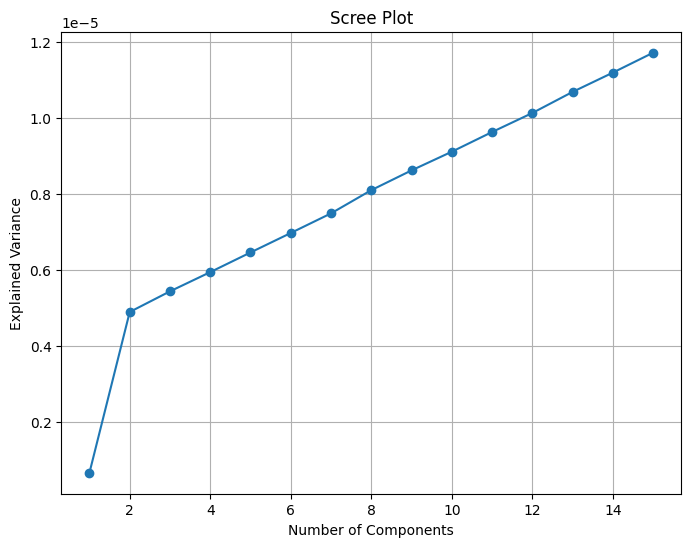